In [1]:
#default_exp multitask_transformer.transform

In [2]:
#export
from musicautobot.imports import *
from musicautobot.music_transformer.transform import *
from musicautobot.numpy_encode import *

class MultitrackItem():
    def __init__(self, melody:MusicItem, chords:MusicItem, stream=None):
        self.melody,self.chords = melody, chords
        self.vocab = melody.vocab
        self._stream = stream
        
    @classmethod
    def from_file(cls, midi_file, vocab):
        return cls.from_stream(file2stream(midi_file), vocab)

    @classmethod
    def from_stream(cls, stream, vocab):
        if not isinstance(stream, music21.stream.Score): stream = stream.voicesToParts()
        num_parts = len(stream.parts)
        sort_pitch = False
        if num_parts > 2: 
            raise ValueError('Could not extract melody and chords from midi file. Please make sure file contains exactly 2 tracks')
        elif num_parts == 1: 
            print('Warning: only 1 track found. Inferring melody/chords')
            stream = separate_melody_chord(stream)
            sort_pitch = False
            
        mpart, cpart = stream2npenc_parts(stream, sort_pitch=sort_pitch)
        return cls.from_npenc_parts(mpart, cpart, vocab, stream)
        
    @classmethod
    def from_npenc_parts(cls, mpart, cpart, vocab, stream=None):
        mpart = npenc2idxenc(mpart, seq_type=SEQType.Melody, vocab=vocab, add_eos=False)
        cpart = npenc2idxenc(cpart, seq_type=SEQType.Chords, vocab=vocab, add_eos=False)
        return MultitrackItem(MusicItem(mpart, vocab), MusicItem(cpart, vocab), stream)
        
    @classmethod
    def from_idx(cls, item, vocab):
        m, c = item
        return MultitrackItem(MusicItem.from_idx(m, vocab), MusicItem.from_idx(c, vocab))
    def to_idx(self): return np.array((self.melody.to_idx(), self.chords.to_idx()))
    
    @property
    def stream(self):
        self._stream = self.to_stream() if self._stream is None else self._stream
        return self._stream
    
    def to_stream(self, bpm=120):
        ps = self.melody.to_npenc(), self.chords.to_npenc()
        ps = [npenc2chordarr(p) for p in ps]
        chordarr = chordarr_combine_parts(ps)
        return chordarr2stream(chordarr, bpm=bpm)

    
    def show(self, format:str=None):
        return self.stream.show(format)
    def play(self): self.stream.show('midi')
        
    def transpose(self, val):
        return MultitrackItem(self.melody.transpose(val), self.chords.transpose(val))
    def pad_to(self, val):
        return MultitrackItem(self.melody.pad_to(val), self.chords.pad_to(val))
    def trim_to_beat(self, beat):
        return MultitrackItem(self.melody.trim_to_beat(beat), self.chords.trim_to_beat(beat))
    
    def __len__(self):
        return max([len(self.melody), len(self.chords)])

def stream2melodychords(stream):
    if not isinstance(stream, music21.stream.Score): stream = stream.voicesToParts()
    stream.quantize(inPlace=True)
    
    ## Should we filter out pitches outside of max keyboard notes here?
    ## Should we set max duration of notes here?
    
    invalid_parts = [p for p in stream.parts if not is_valid_part(p)]
    if invalid_parts: print(f'Found {len(invalid_parts)} invalid parts')
    stream.remove(invalid_parts)
    num_parts = len(stream.parts)
    if num_parts > 2: raise ValueError('Could not extract melody and chords. Midi file must contain exactly 2 tracks')
    elif num_parts == 1:
        stream = separate_melody_chord(stream)

    m, c = list(stream.parts)
    if len(list(m.getElementsByClass('Chord'))) > len(list(c.getElementsByClass('Chord'))):
        raise ValueError('Inverted melody track and chord track. Skipping...')
        
    return stream
def is_valid_part(p, min_pitch_var=3, min_notes=9):
    if isinstance(p.getInstrument(), music21.instrument.Percussion): return False
    pitches = p.pitches
    if len(set(pitches)) < min_pitch_var: return False
    if len(p.pitches) < min_notes: return False
    return True

def combine2chordarr(np1, np2, vocab):
    if len(np1.shape) == 1: np1 = idxenc2npenc(np1, vocab)
    if len(np2.shape) == 1: np2 = idxenc2npenc(np2, vocab)
    p1 = npenc2chordarr(np1)
    p2 = npenc2chordarr(np2)
    return chordarr_combine_parts((p1, p2))


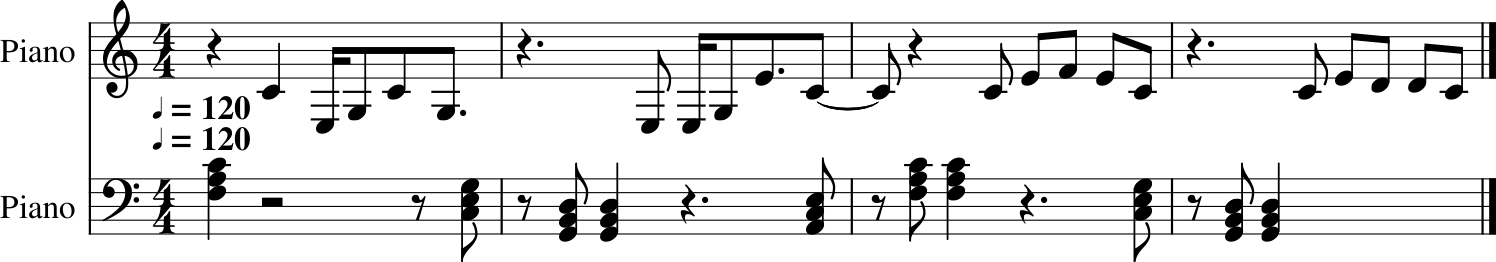

In [8]:
from musicautobot.vocab import *
midi_files =  list(Path('../../data/midi/examples/').glob('*.mid'))
midi_file = midi_files[0]
vocab = MusicVocab.create()
item = MultitrackItem.from_file(midi_file, vocab); item.show()

In [4]:
#hide
from nbdev.export import notebook2script
notebook2script(recursive=True)

Converted config.ipynb.
Converted Train.ipynb.
Converted dataloader.ipynb.
Converted learner.ipynb.
Converted model.ipynb.
Converted transform.ipynb.
Converted Train-Scratch.ipynb.
Converted Train.ipynb.
Converted dataloader-reference.ipynb.
Converted dataloader-v1.ipynb.
Converted dataloader.ipynb.
Converted learner.ipynb.
Converted model.ipynb.
Converted transform.ipynb.
Converted numpy_encode.ipynb.
Converted attention_mask.ipynb.
Converted env_setup.ipynb.
Converted file_processing.ipynb.
Converted lamb.ipynb.
Converted midifile.ipynb.
Converted stacked_dataloader.ipynb.
Converted top_k_top_p.ipynb.
Converted vocab.ipynb.
